TASK 1 - :-  Interest Point Detection, Feature Matching and Contour Detection

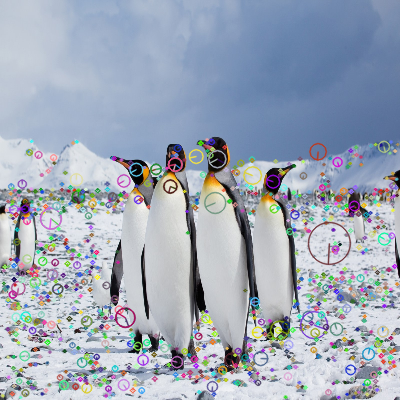

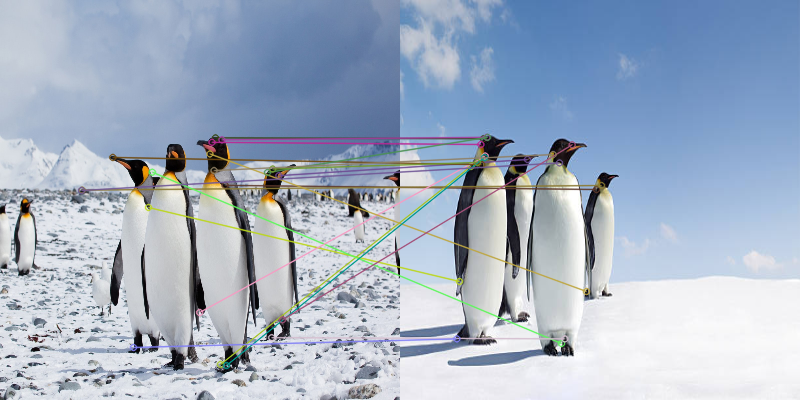

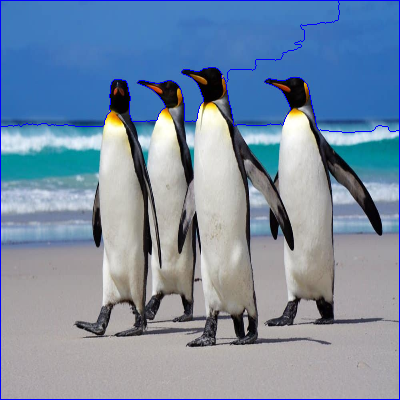

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

img1 = cv2.imread('peng_sm.jpeg')
img2 = cv2.imread('penguin_sample.jpg')

img1 = cv2.resize(img1, (400, 400))
img2 = cv2.resize(img2, (400, 400))

# SIFT (Scale-Invariant Feature Transform)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)

img1_sift = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2_imshow(img1_sift)


# ORB (Oriented FAST and Rotated BRIEF)

orb = cv2.ORB_create()

kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1_orb, des2_orb)

matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, kp1_orb, img2, kp2_orb, matches[:20], None, flags=2)

cv2_imshow(img_matches)

#Contour Detection with Watershed and Custom Seeds

img3 = cv2.imread('peng_3.jpg')
img3 = cv2.resize(img3, (400, 400))
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

img_watershed = img3.copy()
markers = cv2.watershed(img_watershed, markers)
img_watershed[markers == -1] = [255, 0, 0]

cv2_imshow(img_watershed)


TASK 2 - Image Restoration using Autoencoder Model

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 236ms/step - loss: 0.1192 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 136s 224ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 225ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 216ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 221ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 218ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 219ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 221ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 221ms/step - loss: 0.1120 - val_loss: 0.1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Image 1 P

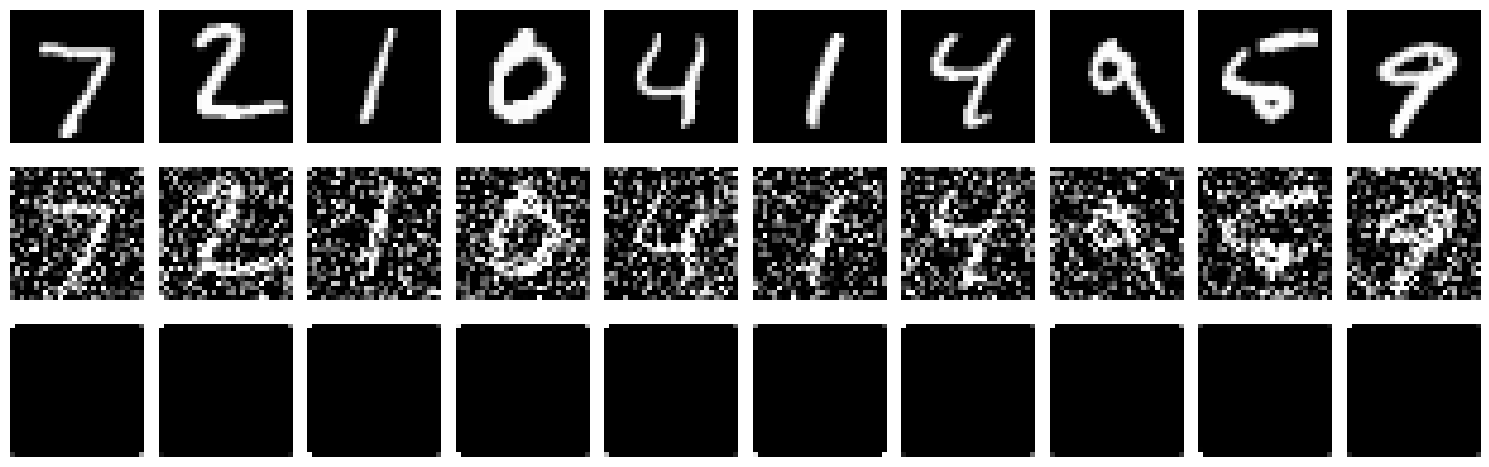

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio as psnr

# Step 1: Load & Preprocess Data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Resize to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Step 2: Simulate Degradation (Add Gaussian Noise)
def add_noise(images):
    noisy = images + np.random.normal(loc=0.0, scale=0.5, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

#Step 3: Build the Autoencoder
def build_autoencoder():
    model = models.Sequential([
        # Encoder
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Decoder
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

# Step 4: Train the Autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Step 5: Image Restoration & Evaluation
restored_images = autoencoder.predict(x_test_noisy[:10])

# Calculate PSNR for first 10 test images
for i in range(10):
    score = psnr(x_test[i], restored_images[i])
    print(f"Image {i+1} PSNR: {score:.2f} dB")

#Plot Original, Noisy, and Restored
plt.figure(figsize=(15, 5))
for i in range(10):
    # Original
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Original")

    # Noisy
    plt.subplot(3, 10, i + 11)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Noisy")

    # Restored
    plt.subplot(3, 10, i + 21)
    plt.imshow(restored_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Restored")

plt.tight_layout()
plt.show()
